## Conversion csv to npz graph file

In [1]:
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd

In [2]:
import os
os.getcwd()

'/content'

In [3]:
df = pd.read_csv('kc_house_data.csv')

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [6]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Convert datetime

In [7]:
df["date"]

0        20141013T000000
1        20141209T000000
2        20150225T000000
3        20141209T000000
4        20150218T000000
              ...       
21608    20140521T000000
21609    20150223T000000
21610    20140623T000000
21611    20150116T000000
21612    20141015T000000
Name: date, Length: 21613, dtype: object

In [8]:
df["date"] = pd.to_datetime(df["date"])
df["date"]

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21608   2014-05-21
21609   2015-02-23
21610   2014-06-23
21611   2015-01-16
21612   2014-10-15
Name: date, Length: 21613, dtype: datetime64[ns]

In [9]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

In [10]:
df = df.drop(["date"], axis=1)
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,360000.0,3,2.50,1530,1131,3.0,0,0,3,...,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,21
21609,6600060120,400000.0,4,2.50,2310,5813,2.0,0,0,3,...,2014,0,98146,47.5107,-122.362,1830,7200,2015,2,23
21610,1523300141,402101.0,2,0.75,1020,1350,2.0,0,0,3,...,2009,0,98144,47.5944,-122.299,1020,2007,2014,6,23
21611,291310100,400000.0,3,2.50,1600,2388,2.0,0,0,3,...,2004,0,98027,47.5345,-122.069,1410,1287,2015,1,16


## MinMaxScaler

In [11]:
from sklearn.preprocessing import MinMaxScaler #The embedding models work when the values are in [0,1]. Need to check if it also works with a standardscaler and normalization.
excluded_cols = ["id", "price", "lat", "long"]
cols_to_scale = [col for col in df.columns if col not in excluded_cols]
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [12]:
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,221900.0,0.090909,0.12500,0.067170,0.003108,0.0,0.0,0.0,0.5,...,0.478261,0.000000,0.893939,47.5112,-122.257,0.161934,0.005742,0.0,0.818182,0.400000
1,6414100192,538000.0,0.090909,0.28125,0.172075,0.004072,0.4,0.0,0.0,0.5,...,0.443478,0.988089,0.626263,47.7210,-122.319,0.222165,0.008027,0.0,1.000000,0.266667
2,5631500400,180000.0,0.060606,0.12500,0.036226,0.005743,0.0,0.0,0.0,0.5,...,0.286957,0.000000,0.136364,47.7379,-122.233,0.399415,0.008513,1.0,0.090909,0.800000
3,2487200875,604000.0,0.121212,0.37500,0.126038,0.002714,0.0,0.0,0.0,1.0,...,0.565217,0.000000,0.681818,47.5208,-122.393,0.165376,0.004996,0.0,1.000000,0.266667
4,1954400510,510000.0,0.090909,0.25000,0.104906,0.004579,0.0,0.0,0.0,0.5,...,0.756522,0.000000,0.368687,47.6168,-122.045,0.241094,0.007871,1.0,0.090909,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,360000.0,0.090909,0.31250,0.093585,0.000370,0.8,0.0,0.0,0.5,...,0.947826,0.000000,0.515152,47.6993,-122.346,0.194631,0.000986,0.0,0.363636,0.666667
21609,6600060120,400000.0,0.121212,0.31250,0.152453,0.003206,0.4,0.0,0.0,0.5,...,0.991304,0.000000,0.732323,47.5107,-122.362,0.246257,0.007523,1.0,0.090909,0.733333
21610,1523300141,402101.0,0.060606,0.09375,0.055094,0.000503,0.4,0.0,0.0,0.5,...,0.947826,0.000000,0.722222,47.5944,-122.299,0.106866,0.001558,0.0,0.454545,0.733333
21611,291310100,400000.0,0.090909,0.31250,0.098868,0.001132,0.4,0.0,0.0,0.5,...,0.904348,0.000000,0.131313,47.5345,-122.069,0.173980,0.000731,1.0,0.000000,0.500000


## Create graph

In [13]:
import geopy
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import node_classification
from networkx.algorithms.community.centrality import girvan_newman

## Take sample


In [14]:
df = df.head(1000)

Create the graph based on the latitude and longitude coordinates of the csv file

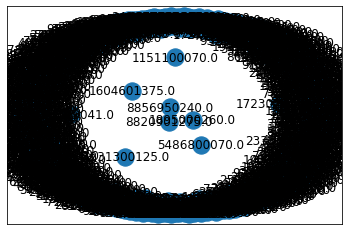

In [16]:
G = nx.Graph()
for index,row in df.iterrows():
    G.add_node(row["id"], pos=(row["lat"], row["long"]))
nx.draw_networkx(G)

Create edges based on a distance threshold delta, input given by user

In [17]:
from geopy.distance import distance

In [18]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[]

In [19]:
threshold = 0.5 # meters

# Loop over all pairs of nodes and add an edge if their distance is below the threshold
i = 1
for u, u_data in G.nodes(data=True):
    print(i)
    i += 1
    for v, v_data in G.nodes(data=True):
        if u < v:
            u_pos = u_data['pos']
            v_pos = v_data['pos']
            dist = distance(u_pos, v_pos).km
            if dist <= threshold:
                G.add_edge(u, v, weight=dist)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


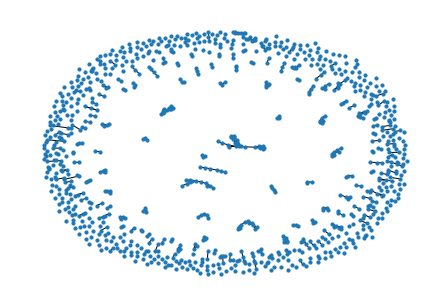

In [21]:
nx.draw(G, node_size=10)

## Create adjacency matrix

In [25]:
A = nx.to_scipy_sparse_matrix(G).astype("float32")
A

<992x992 sparse matrix of type '<class 'numpy.float32'>'
	with 928 stored elements in Compressed Sparse Row format>

Graph needs to satisfy the following conditions
- It cannot have self-loops, in other words the diagonal of the adjacency matrix must contain zero values
- There cannot be any dangling nodes, every node needs to be connected in the graph

In [20]:
# Check for self-loops
G.remove_edges_from(nx.selfloop_edges(G))

In [23]:
import scipy as sp

In [25]:
!pip install 'networkx<2.7'

!pip install 'scipy>=1.8'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.7 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
# Check for dangling nodes
has_dangling_nodes = sp.linalg.norm(sp.sparse.csr_matrix.sum(A, axis=1) - 1) > 1e-10

if has_dangling_nodes:
    print('The graph has dangling nodes')
    dangling_nodes = [node for node in G.nodes() if not G.degree[node] >0]
    print(len(dangling_nodes))
    G.remove_nodes_from(dangling_nodes)
else:
    print('The graph does not have dangling nodes')

The graph has dangling nodes
437


In [34]:
dangling_nodes = [node for node in G.nodes() if not G.degree[node] >0]
print(len(dangling_nodes))
print(G)

0
Graph with 555 nodes and 464 edges


## Create scipy sparce attribute matrix

In [33]:
df_numpy = df.to_numpy()
attr_matrix = csr_matrix(df_numpy).astype("float32")
attr_matrix

<1000x23 sparse matrix of type '<class 'numpy.float32'>'
	with 18220 stored elements in Compressed Sparse Row format>

# Check if this is above zero, if it is then there are self-loops left - which is not allowed
A.diagonal().sum()

## Save graph as npz file

The code of das et al includes labels if it's present, if it's not then label is set to "None".

Price is given separately in the code.

The code of das et al requires different POIs, so it has to be a heterogeneous graph. The attribute data needs to be in order according to this.

In [35]:
np.savez('FINALEDUMMYDATASET.npz', edges = G.edges, adj_data=A.data, adj_indices=A.indices, adj_indptr=A.indptr,
         adj_shape=A.shape, attr_data=attr_matrix.data, attr_indices=attr_matrix.indices, attr_indptr=attr_matrix.indptr,
         attr_shape=attr_matrix.shape, labels=df["price"])